In [518]:
#imports
import pandas as pd 
from slugify import slugify
import requests
from tqdm.notebook import tqdm
from time import sleep
from bs4 import BeautifulSoup as bs
import json
from datetime import datetime
import webbrowser
from tqdm.notebook import tqdm
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [470]:
#getting both csv files 
movie_details = pd.read_csv('/Users/armaan/src/bbox/mdata/thenum/movie_details.csv') 
imdb_movies = pd.read_csv('/Users/armaan/src/bbox/mdata/imdb/imdb_movies.csv') 
#converting names to lower and some cols to int
movie_details['name_lower'] = movie_details['name'].str.lower()
imdb_movies['year'] = pd.to_numeric(imdb_movies.startYear, errors='coerce')
imdb_movies['primaryTitle_lower'] = imdb_movies['primaryTitle'].str.lower()
imdb_movies['runtimeMinutes'] = pd.to_numeric(imdb_movies.runtimeMinutes, errors='coerce')

In [471]:
#normalization
def normalize(x):
    if x:
        #for star wars
        x = x.replace('-ep-', '-episode-')
        #for harry potter
        x = x.replace('part-ii', 'part-2')
        x = x.replace('part-i', 'part-1')
        #for e.t. only!
        if x.startswith('et-'):
            x = x.replace('et-', 'e-t-')
        #for rise of skywalker only!
        if x == 'star-wars-the-rise-of-skywalker':
            x = "star-wars-episode-ix-the-rise-of-skywalker"
    return x

#find duplicates
def duplicate_scraper(imdb_id):
    r = requests.get("https://www.imdb.com/title/{}/".format(imdb_id))
    soup = bs(r.text)
    if soup.find("h3",{"class": "subheading"}).string == "Box Office":
        drop = False
    else:
        drop = True 
    return drop

In [472]:
#sluggifying and normalizing all names
movie_details['name_slug'] = movie_details.name_lower.apply(slugify)
imdb_movies['name_slug'] = imdb_movies.primaryTitle_lower.apply(slugify)
movie_details['name_slug'] = movie_details.name_slug.apply(normalize)
#creating new df with updated values
new_df = pd.merge(movie_details, imdb_movies, how ='inner', right_on = ['name_slug', 'year'], left_on = ['name_slug', 'year'])

In [473]:
#find duplicates and get rid of them
duplicates = new_df[new_df.name.duplicated()]
for index, row in tqdm(duplicates.iterrows()):
    match = new_df[(new_df['name'] == row["name"]) & (new_df['year'] == row["year"])]
    if len(match) > 1:
        imdb_ids = match["tconst"]
        for imdb_id in imdb_ids:
            drop = duplicate_scraper(imdb_id)
            if drop == True:
                new_df.drop( new_df[ new_df['tconst'] == imdb_id ].index , inplace=True)

In [474]:
#drops
new_df.drop(["endYear", "isAdult", "titleType", "startYear", "primaryTitle_lower", "runtimeMinutes", "genres", "name_lower", "name_slug", "primaryTitle", "originalTitle"], axis=1, inplace = True)

In [475]:
#get poster path and add it to new col in df
poster_link_list = []
for p in tqdm(new_df['tconst']):
    tmdb = requests.get("https://api.themoviedb.org/3/movie/{}?api_key=a6837e56522d89b354d01b07e393bebc&language=en-US".format(p))
    poster_path = tmdb.json()['poster_path']
    poster_link = "https://image.tmdb.org/t/p/w300_and_h450_bestv2/{}".format(poster_path)
    poster_link_list.append(poster_link)

new_df["poster_path"] = poster_link_list

In [500]:
bbox_df.worldwide_box_office.max()

2797800564

In [525]:
bbox_df = new_df

bbox_df['bb_profit'] = bbox_df.worldwide_box_office - bbox_df.production_budget
bbox_df['bb_profit_multiple'] = bbox_df.worldwide_box_office/bbox_df.worldwide_box_office

bbox_df['bb_profit_score'] = (bbox_df.bb_profit / bbox_df.bb_profit.max()) * 100
bbox_df['bb_profit_multiple_score'] = (bbox_df.bb_profit_multiple / bbox_df.bb_profit_multiple.max()) * 100

bbox_df['bb_score'] = (bbox_df['bb_profit_score']*0.7 + bbox_df['bb_profit_multiple_score']*0.3)
bbox_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 101
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      100 non-null    object 
 1   year                      100 non-null    int64  
 2   domestic_box_office       100 non-null    int64  
 3   international_box_office  100 non-null    int64  
 4   worldwide_box_office      100 non-null    int64  
 5   opening_weekend           100 non-null    int64  
 6   legs                      100 non-null    float64
 7   production_budget         100 non-null    int64  
 8   theater_counts            100 non-null    float64
 9   mpaa_rating               100 non-null    object 
 10  running_time              100 non-null    int64  
 11  genre                     100 non-null    object 
 12  production_method         100 non-null    object 
 13  creative_type             100 non-null    object 
 14  production

In [528]:
bbox_df.bb_score.describe() 
bbox_df.sort_values(by='bb_score', ascending=False)

,name,year,domestic_box_office,international_box_office,worldwide_box_office,opening_weekend,legs,production_budget,theater_counts,mpaa_rating,...,synopsis,link,tconst,poster_path,bb_profit,bb_profit_multiple,bb_profit_score,bb_multiple_score,bb_profit_multiple_score,bb_score
2,Avatar,2009,760507625,2028193712,2788701337,77025481,9.87,237000000,13.20,PG-13,...,"Jake Sully is a wounded ex-marine, thrust into...",https://www.the-numbers.com/movie/Avatar#tab=s...,tt0499549,https://image.tmdb.org/t/p/w300_and_h450_bestv...,2551701337,1.00,100.00,59.25,100.00,100.00
1,Avengers: Endgame,2019,858373000,1939427564,2797800564,357115007,2.40,400000000,8.10,PG-13,...,The grave course of events set in motion by Th...,https://www.the-numbers.com/movie/Avengers-End...,tt4154796,https://image.tmdb.org/t/p/w300_and_h450_bestv...,2397800564,1.00,93.97,100.00,100.00,95.78
5,Titanic,1997,659363944,1548844451,2208208395,28638131,18.60,200000000,26.80,PG-13,...,NaN,https://www.the-numbers.com/movie/Titanic-(199...,tt0120338,https://image.tmdb.org/t/p/w300_and_h450_bestv...,2008208395,1.00,78.70,50.00,100.00,85.09
0,Star Wars Ep. VII: The Force Awakens,2015,936662225,1131561399,2068223624,247966675,3.78,306000000,9.20,PG-13,...,"Rey, a scavenger from the planet Jakku, and re...",https://www.the-numbers.com/movie/Star-Wars-Ep...,tt2488496,https://image.tmdb.org/t/p/w300_and_h450_bestv...,1762223624,1.00,69.06,76.50,100.00,78.34
4,Avengers: Infinity War,2018,678815482,1369544272,2048359754,257698183,2.63,300000000,7.70,PG-13,...,As the Avengers and their allies have continue...,https://www.the-numbers.com/movie/Avengers-Inf...,tt4154756,https://image.tmdb.org/t/p/w300_and_h450_bestv...,1748359754,1.00,68.52,75.00,100.00,77.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,American Sniper,2014,350126372,197200000,547326372,633456,3.92,58000000,8.90,R,...,U.S. Navy SEAL Chris Kyle is sent to Iraq with...,https://www.the-numbers.com/movie/American-Sni...,tt2179136,https://image.tmdb.org/t/p/w300_and_h450_bestv...,489326372,1.00,19.18,14.50,100.00,43.42
81,Iron Man 2,2010,312433331,308723058,621156389,128122480,2.44,170000000,6.20,PG-13,...,"With the world now aware that he is Iron Man, ...",https://www.the-numbers.com/movie/Iron-Man-2#t...,tt1228705,https://image.tmdb.org/t/p/w300_and_h450_bestv...,451156389,1.00,17.68,42.50,100.00,42.38
99,Man of Steel,2013,291045518,376954000,667999518,116619362,2.50,225000000,5.00,PG-13,...,A young boy learns that he has extraordinary p...,https://www.the-numbers.com/movie/Man-of-Steel...,tt0770828,https://image.tmdb.org/t/p/w300_and_h450_bestv...,442999518,1.00,17.36,56.25,100.00,42.15
84,Star Wars Ep. VI: Return of the Jedi,1983,309205079,165901098,475106177,23019618,13.43,32500000,19.10,PG,...,NaN,https://www.the-numbers.com/movie/Star-Wars-Ep...,tt0086190,https://image.tmdb.org/t/p/w300_and_h450_bestv...,442606177,1.00,17.35,8.12,100.00,42.14


In [524]:
bbox_df.bb_multiple_score.describe()
bbox_df.sort_values(by="bb_profit", ascending=True)

,name,year,domestic_box_office,international_box_office,worldwide_box_office,opening_weekend,legs,production_budget,theater_counts,mpaa_rating,...,synopsis,link,tconst,poster_path,bb_profit,bb_profit_multiple,bb_profit_score,bb_multiple_score,bb_profit_multiple_score,bb_score
75,Iron Man,2008,318604126,266567421,585171547,102118668,3.12,186000000,8.00,PG-13,...,"Tony Stark, a billionaire industrialist and ge...",https://www.the-numbers.com/movie/Iron-Man#tab...,tt0371746,https://image.tmdb.org/t/p/w300_and_h450_bestv...,399171547,1.00,15.64,46.50,100.00,57.82
84,Star Wars Ep. VI: Return of the Jedi,1983,309205079,165901098,475106177,23019618,13.43,32500000,19.10,PG,...,NaN,https://www.the-numbers.com/movie/Star-Wars-Ep...,tt0086190,https://image.tmdb.org/t/p/w300_and_h450_bestv...,442606177,1.00,17.35,8.12,100.00,58.67
99,Man of Steel,2013,291045518,376954000,667999518,116619362,2.50,225000000,5.00,PG-13,...,A young boy learns that he has extraordinary p...,https://www.the-numbers.com/movie/Man-of-Steel...,tt0770828,https://image.tmdb.org/t/p/w300_and_h450_bestv...,442999518,1.00,17.36,56.25,100.00,58.68
81,Iron Man 2,2010,312433331,308723058,621156389,128122480,2.44,170000000,6.20,PG-13,...,"With the world now aware that he is Iron Man, ...",https://www.the-numbers.com/movie/Iron-Man-2#t...,tt1228705,https://image.tmdb.org/t/p/w300_and_h450_bestv...,451156389,1.00,17.68,42.50,100.00,58.84
56,American Sniper,2014,350126372,197200000,547326372,633456,3.92,58000000,8.90,R,...,U.S. Navy SEAL Chris Kyle is sent to Iraq with...,https://www.the-numbers.com/movie/American-Sni...,tt2179136,https://image.tmdb.org/t/p/w300_and_h450_bestv...,489326372,1.00,19.18,14.50,100.00,59.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,Avengers: Infinity War,2018,678815482,1369544272,2048359754,257698183,2.63,300000000,7.70,PG-13,...,As the Avengers and their allies have continue...,https://www.the-numbers.com/movie/Avengers-Inf...,tt4154756,https://image.tmdb.org/t/p/w300_and_h450_bestv...,1748359754,1.00,68.52,75.00,100.00,84.26
0,Star Wars Ep. VII: The Force Awakens,2015,936662225,1131561399,2068223624,247966675,3.78,306000000,9.20,PG-13,...,"Rey, a scavenger from the planet Jakku, and re...",https://www.the-numbers.com/movie/Star-Wars-Ep...,tt2488496,https://image.tmdb.org/t/p/w300_and_h450_bestv...,1762223624,1.00,69.06,76.50,100.00,84.53
5,Titanic,1997,659363944,1548844451,2208208395,28638131,18.60,200000000,26.80,PG-13,...,NaN,https://www.the-numbers.com/movie/Titanic-(199...,tt0120338,https://image.tmdb.org/t/p/w300_and_h450_bestv...,2008208395,1.00,78.70,50.00,100.00,89.35
1,Avengers: Endgame,2019,858373000,1939427564,2797800564,357115007,2.40,400000000,8.10,PG-13,...,The grave course of events set in motion by Th...,https://www.the-numbers.com/movie/Avengers-End...,tt4154796,https://image.tmdb.org/t/p/w300_and_h450_bestv...,2397800564,1.00,93.97,100.00,100.00,96.98


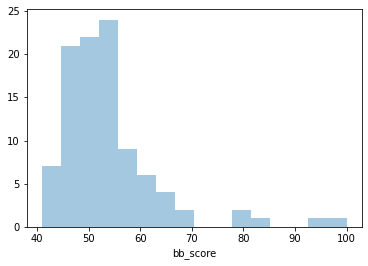

In [527]:
sns.distplot(bbox_df['bb_score'],kde = False)


In [522]:
#downloads df to csv
bbox_df.to_csv('/Users/armaan/src/bbox/mdata/master_table.csv', index=False)